# FizHugh-Nagumo Simulator

Let

$$ f(V) = V - \frac{1}{3}V^3, \quad \epsilon = \frac{1}{\tau} $$

_Single-Neuron Network:_

$$ \frac{dV}{dt} = g_1(V, W, I) = f(V) - W + I $$

$$ \frac{dW}{dt} = g_2(V, W) = \epsilon (V - aW + b) $$

_Unidirectional Dual-Neuron Network:_

$$ \frac{dV_1}{dt} = g_1(V_1, W_1, I) = f(V_1) - W_1 + I $$

$$ \frac{dW_1}{dt} = g_2(V_1, W_1) = \epsilon (V_1 - aW_1 + b) $$

$$ \frac{dV_2}{dt} = g_1(V_2, W_2, I) = f(V_2) - W_2 + \gamma(V_1 - V_2) $$

$$ \frac{dW_2}{dt} = g_2(V_2, W_2) = \epsilon (V_2 - aW_2 + b) $$

In [10]:
import numpy as np
import numbers
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
sns.set(style='whitegrid')

In [11]:
# Derivatives (RHS of differential equations)

def g1(V, W, I):
    return V - (1/3)*V**3 - W + I


def g2(V, W, tau, a, b):
    return (1/tau)*(V - a*W + b)

In [12]:
def rk4_xmtr(V0, W0, h, N, tau, a_arr, b_arr, I_arr):
    '''
    Runge-Kutta solver for transmitting neuron
    
    Parameters
    ----------
    (V0, W0) = initial point in phase space
    h = step size
    N = number of steps to simulate for
    tau = time scale constant
    a, b, I = parameters of FHN
    
    I_arr = impulse current in transmitting neuron
    '''

    V_arr = np.zeros(N, dtype=np.float128)
    W_arr = np.zeros(N, dtype=np.float128)

    V_arr[0] = V0
    W_arr[0] = W0

    for i in range(N-1):
        k0 = h*g1(V_arr[i], W_arr[i], I_arr[i])
        l0 = h*g2(V_arr[i], W_arr[i], tau, a_arr[i], b_arr[i])
        k1 = h*g1(V_arr[i] + 0.5*k0, W_arr[i] + 0.5*l0, I_arr[i])
        l1 = h*g2(V_arr[i] + 0.5*k0, W_arr[i] + 0.5*l0, tau, a_arr[i], b_arr[i])
        k2 = h*g1(V_arr[i] + 0.5*k1, W_arr[i] + 0.5*l1, I_arr[i])
        l2 = h*g2(V_arr[i] + 0.5*k1, W_arr[i] + 0.5*l1, tau, a_arr[i], b_arr[i])
        k3 = h*g1(V_arr[i] + k2, W_arr[i] + l2, I_arr[i])
        l3 = h*g2(V_arr[i] + k2, W_arr[i] + l2, tau, a_arr[i], b_arr[i])
        
        V_arr[i+1] = V_arr[i] + (1/6)*(k0 + 2*k1 + 2*k2 + k3)
        W_arr[i+1] = W_arr[i] + (1/6)*(l0 + 2*l1 + 2*l2 + l3)
        
    return V_arr, W_arr

In [13]:
def rk4_rcvr(V0, W0, h, N, tau, a_arr, b_arr, gamma, V1_arr):
    '''
    Runge-Kutta solver for the receiving neuron
    
    Parameters
    ----------
    (V0, W0) = initial point in phase space
    h = step size
    N = number of steps to simulate for
    tau = time scale constant
    a, b, I = parameters of FHN
    
    gamma = proportionality constant of 
    V1_arr = voltage of the transmitting neuron
    '''

    V_arr = np.zeros(N, dtype=np.float128)
    W_arr = np.zeros(N, dtype=np.float128)

    V_arr[0] = V0
    W_arr[0] = W0

    for i in range(N-1):
        k0 = h*g1(V_arr[i], W_arr[i], gamma*(V1_arr[i]-V_arr[i]))
        l0 = h*g2(V_arr[i], W_arr[i], tau, a_arr[i], b_arr[i])
        k1 = h*g1(V_arr[i] + 0.5*k0, W_arr[i] + 0.5*l0, gamma*(V1_arr[i]-V_arr[i]))
        l1 = h*g2(V_arr[i] + 0.5*k0, W_arr[i] + 0.5*l0, tau, a_arr[i], b_arr[i])
        k2 = h*g1(V_arr[i] + 0.5*k1, W_arr[i] + 0.5*l1, gamma*(V1_arr[i]-V_arr[i]))
        l2 = h*g2(V_arr[i] + 0.5*k1, W_arr[i] + 0.5*l1, tau, a_arr[i], b_arr[i])
        k3 = h*g1(V_arr[i] + k2, W_arr[i] + l2, gamma*(V1_arr[i]-V_arr[i]))
        l3 = h*g2(V_arr[i] + k2, W_arr[i] + l2, tau, a_arr[i], b_arr[i])
        
        V_arr[i+1] = V_arr[i] + (1/6)*(k0 + 2*k1 + 2*k2 + k3)
        W_arr[i+1] = W_arr[i] + (1/6)*(l0 + 2*l1 + 2*l2 + l3)
        
    return V_arr, W_arr

In [14]:
def single_fhn(V0, W0, h, N, tau=None, a=None, b=None, I=None, ax=None):
    '''
    Plots a phase portrait of the FitzHugh-Nagumo neuron
    
    Parameters
    ----------
    (V0, W0) = initial point in phase space
    h = step size
    N = number of steps to simulate for
    tau = time scale constant; defaults to 12.5 ("sufficiently large")
    a, b, I = parameters of FHN; default to 1, 1, 0
    '''
    
    if tau is None:
        tau = 12.5
    if a is None:
        a = 1
    if isinstance(a, numbers.Number):
        a_arr = np.repeat(a, N)
    else:
        a_arr = a
    if b is None:
        b = 1
    if isinstance(b, numbers.Number):
        b_arr = np.repeat(b, N)
    else:
        b_arr = b
    if I is None:
        I = 0
    if isinstance(I, numbers.Number):
        I_arr = np.repeat(I, N)
    else:
        I_arr = I
    if ax is None:
        ax = plt.gca()
    
    V_arr, W_arr = rk4_xmtr(V0, W0, h, N, tau, a_arr, b_arr, I_arr)

    # Plot phase trajectory
    ax.scatter(V_arr, W_arr,
               c=np.linspace(10, 0, N),
               cmap=cm.jet,
               marker='.')

    x_bottom, x_top = ax.get_xlim()
    y_bottom, y_top = ax.get_ylim()

    # Plot nullclines, if a, b, I are constants
    x = np.linspace(x_bottom, x_top)

    try:
        V_nullcline = x - (1/3)*x**3 + I
        ax.plot(x, V_nullcline, color='m', linestyle='--')
    except:
        pass

    try:
        W_nullcline = (1/a) * (x + b)
        ax.plot(x, W_nullcline, color='k', linestyle='--')
    except ZeroDivisionError:
        ax.axvline(-b, y_bottom, y_top, color='k', linestyle='--')

    ax.spines['left'].set_position('zero')
    ax.spines['bottom'].set_position('zero')
    sns.despine()

    return V_arr, W_arr, ax

In [15]:
def dual_fhn(V0_1, W0_1, V0_2, W0_2, h, N, tau=None, a=None, b=None, I=None, gamma=None, axarr=None):
    '''
    Plots a phase portrait of the FitzHugh-Nagumo neuron
    
    Parameters
    ----------
    (V0, W0) = initial point in phase space
    h = step size
    N = number of steps to simulate for
    tau = time scale constant; defaults to 12.5 ("sufficiently large")
    a, b, I = parameters of FHN; default to 1, 1, 0
    '''
    
    if tau is None:
        tau = 12.5
    if a is None:
        a = 0.8
    if isinstance(a, numbers.Number):
        a_arr = np.repeat(a, N)
    else:
        a_arr = a
    if b is None:
        b = 0.7
    if isinstance(b, numbers.Number):
        b_arr = np.repeat(b, N)
    else:
        b_arr = b
    if gamma is None:
        gamma = 1
    if I is None:
        I = 0
    if isinstance(I, numbers.Number):
        I_arr = np.repeat(I, N)
    else:
        I_arr = I

    if axarr is None:
        fig, axarr = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True, figsize=[14, 12])

    V1_arr, W1_arr = rk4_xmtr(V0_1, W0_1, h, N, tau, a_arr, b_arr, I_arr)
    V2_arr, W2_arr = rk4_rcvr(V0_2, W0_2, h, N, tau, a_arr, b_arr, gamma, V1_arr)

    # Plot phase trajectory
    axarr[0].scatter(V1_arr, W1_arr,
                     c=np.linspace(10, 0, N),
                     cmap=cm.jet,
                     marker='.')
    
    axarr[1].scatter(V2_arr, W2_arr,
                     c=np.linspace(10, 0, N),
                     cmap=cm.jet,
                     marker='.')

    x_bottom, x_top = axarr[0].get_xlim()
    y_bottom, y_top = axarr[0].get_ylim()

    # Plot nullclines, if a, b, I are constants
    #x = np.linspace(x_bottom, x_top)
    x = np.linspace(-1.7, 0.5)

    try:
        V_nullcline = x - (1/3)*x**3 + I
        axarr[0].plot(x, V_nullcline, color='m', linestyle='--')
    except:
        pass

    try:
        W_nullcline = (1/a) * (x + b)
        axarr[0].plot(x, W_nullcline, color='k', linestyle='--')
    except ZeroDivisionError:
        axarr[0].axvline(-b, y_bottom, y_top, color='k', linestyle='--')

    axarr[0].spines['left'].set_position('zero')
    axarr[0].spines['bottom'].set_position('zero')
    axarr[1].spines['left'].set_position('zero')
    axarr[1].spines['bottom'].set_position('zero')
    sns.despine()
    
    return V1_arr, W1_arr, V2_arr, W2_arr, axarr

## Single Neuron Illustrations

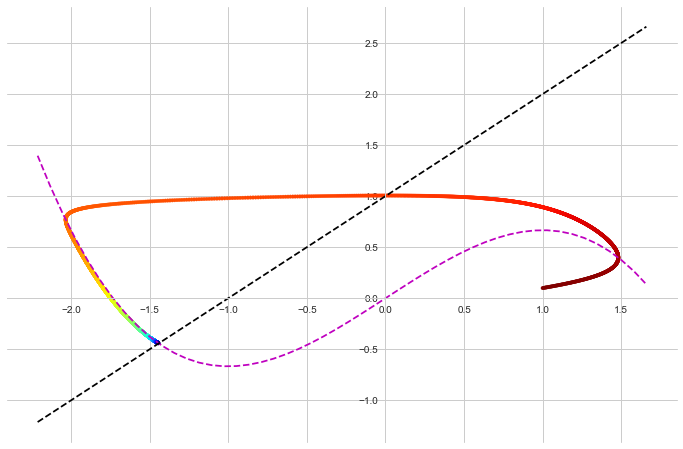

In [35]:
# Single neuron, parameters from squid giant axon
fig, ax = plt.subplots(figsize=[12, 8])
single_fhn(1, 0.1, 0.01, 5000, ax=ax)
plt.show()

In [116]:
# Unit step impulse
I_unitstep = np.zeros(10000)
I_unitstep[2000:] = 0.5

# Boxcar impulse
I_boxcar = np.zeros(10000)
I_boxcar[2000:4000] = 0.5

# Squarewave impulse
I_squarewave = np.zeros(10000)
I_squarewave[2000:4000] = 0.5
I_squarewave[6000:8000] = 0.5

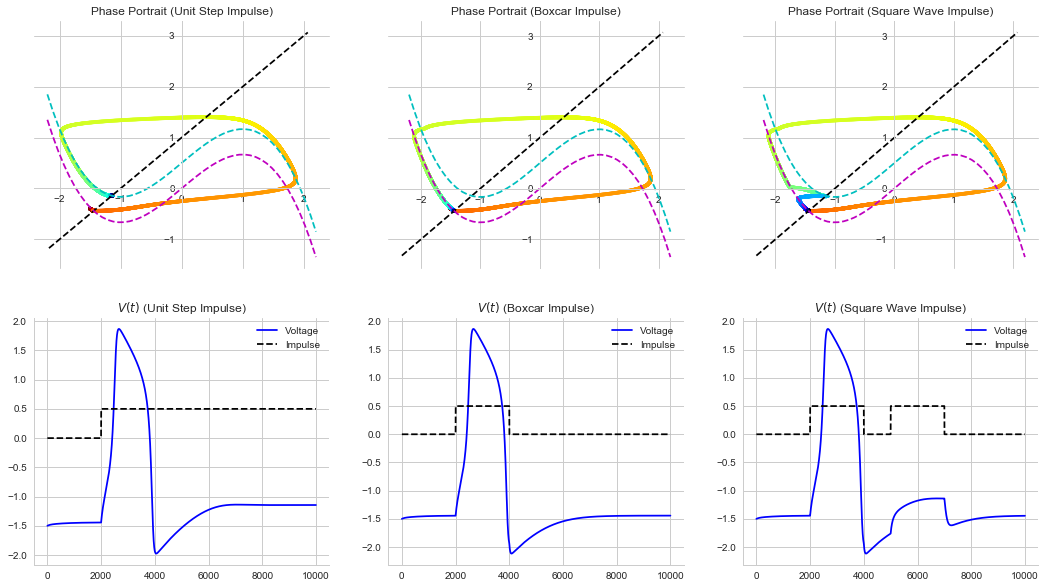

In [144]:
# Single neuron output voltage as a function of input current

fig, axarr = plt.subplots(nrows=2, ncols=3, figsize=[18, 10])
V_unitstep, W_unitstep, _ = single_fhn(-1.5, -0.4, 0.01, 10000, I=I_unitstep, ax=axarr[0, 0])
V_boxcar, W_boxcar, _ = single_fhn(-1.5, -0.4, 0.01, 10000, I=I_boxcar, ax=axarr[0, 1])
V_squarewave, W_squarewave, _ = single_fhn(-1.5, -0.4, 0.01, 10000, I=I_squarewave, ax=axarr[0, 2])

## Plot both nullclines by hand, as single_fhn only plots it if there is a single V nullcline
x = np.linspace(-2.2, 2.2)
nullcline_0 = x - (1/3)*x**3
nullcline_1 = x - (1/3)*x**3 + 0.5
axarr[0, 0].set_title('Phase Portrait (Unit Step Impulse)')
axarr[0, 0].plot(x, nullcline_0, 'm--')
axarr[0, 0].plot(x, nullcline_1, 'c--')
axarr[0, 1].set_title('Phase Portrait (Boxcar Impulse)')
axarr[0, 1].plot(x, nullcline_0, 'm--')
axarr[0, 1].plot(x, nullcline_1, 'c--')
axarr[0, 2].set_title('Phase Portrait (Square Wave Impulse)')
axarr[0, 2].plot(x, nullcline_0, 'm--')
axarr[0, 2].plot(x, nullcline_1, 'c--')

## Plot
axarr[1, 0].plot(range(10000), V_unitstep, 'b', label='Voltage')
axarr[1, 1].plot(range(10000), V_boxcar, 'b', label='Voltage')
axarr[1, 2].plot(range(10000), V_squarewave, 'b', label='Voltage')
axarr[1, 0].plot(range(10000), I_unitstep, 'k--', label='Impulse')
axarr[1, 1].plot(range(10000), I_boxcar, 'k--', label='Impulse')
axarr[1, 2].plot(range(10000), I_squarewave, 'k--', label='Impulse')
axarr[1, 0].legend()
axarr[1, 1].legend()
axarr[1, 2].legend()
axarr[1, 0].set_title('$V(t)$ (Unit Step Impulse)')
axarr[1, 1].set_title('$V(t)$ (Boxcar Impulse)')
axarr[1, 2].set_title('$V(t)$ (Square Wave Impulse)')

plt.show()

## Dual Neuron Illustrations

In [16]:
# Unit step impulse
I_unitstep = np.zeros(10000)
I_unitstep[2000:] = 0.5

# Boxcar impulse
I_boxcar = np.zeros(10000)
I_boxcar[2000:6000] = 0.5

# Squarewave impulse
I_squarewave = np.zeros(10000)
I_squarewave[2000:6000] = 0.5
I_squarewave[8000:] = 0.5

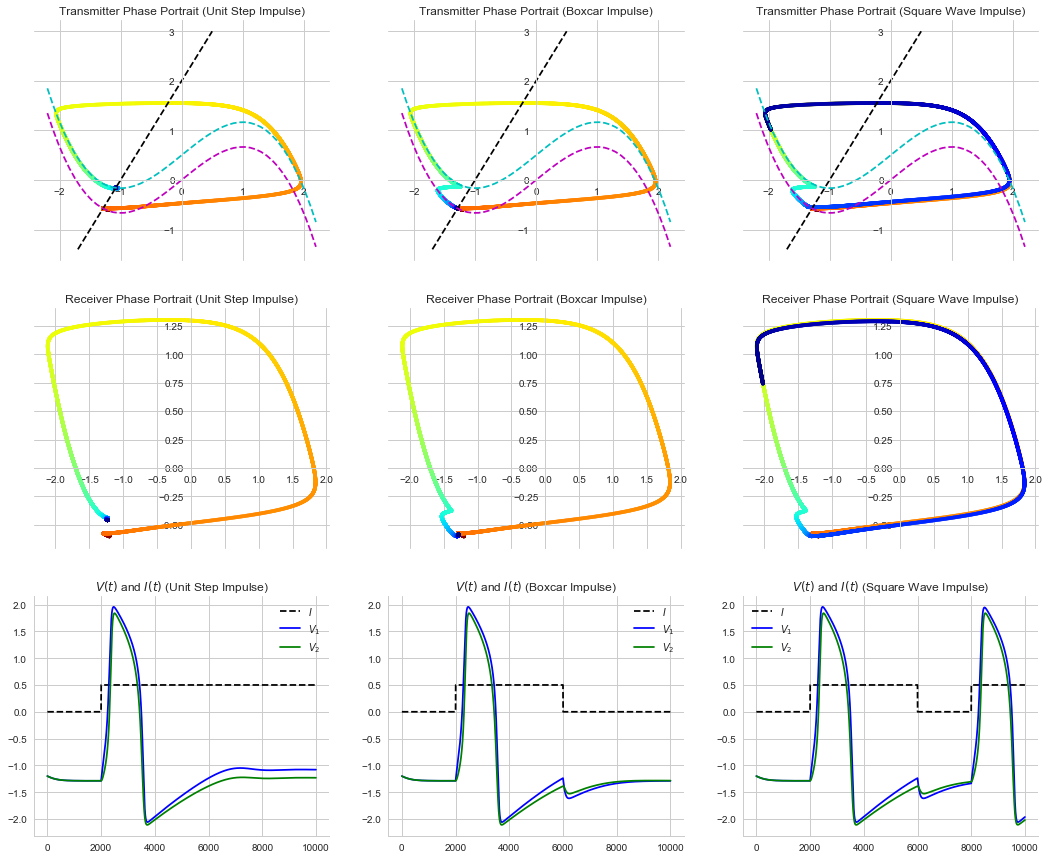

In [18]:
# Dual neuron output voltage as a function of input current

fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=[18, 15])
V1_unitstep, W1_unitstep, V2_unitstep, W2_unitstep, _ = \
    dual_fhn(-1.2, -0.6, -1.2, -0.6, 0.01, 10000, a=0.5, b=1, I=I_unitstep, axarr=axarr[:, 0])
V1_boxcar, W1_boxcar, V2_boxcar, W2_boxcar, _ = \
    dual_fhn(-1.2, -0.6, -1.2, -0.6, 0.01, 10000, a=0.5, b=1, I=I_boxcar, axarr=axarr[:, 1])
V1_squarewave, W1_squarewave, V2_squarewave, W2_squarewave, _ = \
    dual_fhn(-1.2, -0.6, -1.2, -0.6, 0.01, 10000, a=0.5, b=1, I=I_squarewave, axarr=axarr[:, 2])

## Plot both nullclines by hand, as single_fhn only plots it if there is a single V nullcline
x = np.linspace(-2.2, 2.2)
nullcline_0 = x - (1/3)*x**3
nullcline_1 = x - (1/3)*x**3 + 0.5
axarr[0, 0].set_title('Transmitter Phase Portrait (Unit Step Impulse)')
axarr[0, 0].plot(x, nullcline_0, 'm--')
axarr[0, 0].plot(x, nullcline_1, 'c--')
axarr[0, 1].set_title('Transmitter Phase Portrait (Boxcar Impulse)')
axarr[0, 1].plot(x, nullcline_0, 'm--')
axarr[0, 1].plot(x, nullcline_1, 'c--')
axarr[0, 2].set_title('Transmitter Phase Portrait (Square Wave Impulse)')
axarr[0, 2].plot(x, nullcline_0, 'm--')
axarr[0, 2].plot(x, nullcline_1, 'c--')

axarr[1, 0].set_title('Receiver Phase Portrait (Unit Step Impulse)')
axarr[1, 1].set_title('Receiver Phase Portrait (Boxcar Impulse)')
axarr[1, 2].set_title('Receiver Phase Portrait (Square Wave Impulse)')

## Plot
axarr[2, 0].plot(range(10000), I_unitstep, 'k--', label='$I$')
axarr[2, 1].plot(range(10000), I_boxcar, 'k--', label='$I$')
axarr[2, 2].plot(range(10000), I_squarewave, 'k--', label='$I$')
axarr[2, 0].plot(range(10000), V1_unitstep, 'b', label='$V_1$')
axarr[2, 1].plot(range(10000), V1_boxcar, 'b', label='$V_1$')
axarr[2, 2].plot(range(10000), V1_squarewave, 'b', label='$V_1$')
axarr[2, 0].plot(range(10000), V2_unitstep, 'g', label='$V_2$')
axarr[2, 1].plot(range(10000), V2_boxcar, 'g', label='$V_2$')
axarr[2, 2].plot(range(10000), V2_squarewave, 'g', label='$V_2$')
axarr[2, 0].legend()
axarr[2, 1].legend()
axarr[2, 2].legend()
axarr[2, 0].set_title('$V(t)$ and $I(t)$ (Unit Step Impulse)')
axarr[2, 1].set_title('$V(t)$ and $I(t)$ (Boxcar Impulse)')
axarr[2, 2].set_title('$V(t)$ and $I(t)$ (Square Wave Impulse)')

fig.savefig('dual_neuron.png')
plt.show()